# Challenges in Computational Linguistics
## SemEval 2020: Commonsense Validation and Explanation

We're participating in task 4 of the SemEval 2020 Challenges for our seminar Challenges in Computational Linguistics, University Tübingen.

This notebook is meant as playground and first steps, to get the ball rolling. It can later be used as a template to build the final notebook (or program).

## The Data
### Read-in for task 1

First I use the given data from the tasks github respo for subtask A.

https://github.com/wangcunxiang/SemEval2020-Task4-Commonsense-Validation-and-Explanation/tree/master/Training%20%20Data


In [1]:
"""Imports for data"""
import pandas as pd
import numpy as np
import matplotlib as mpl

In [7]:
"""Read in the data directly from github"""
url_data_task_A = "https://raw.githubusercontent.com/wangcunxiang/SemEval2020-Task4-Commonsense-Validation-and-Explanation/master/Training%20%20Data/subtaskA_data_all.csv"
url_answers_task_A = "https://raw.githubusercontent.com/wangcunxiang/SemEval2020-Task4-Commonsense-Validation-and-Explanation/master/Training%20%20Data/subtaskA_answers_all.csv"

data_task_A = pd.read_csv(url_data_task_A,header=0, index_col=0)
answers_task_A = pd.read_csv(url_answers_task_A, index_col=0, header=None)

print(data_task_A[:3])
answers_task_A[:3]

                                    sent0                          sent1
id                                                                      
0   He poured orange juice on his cereal.  He poured milk on his cereal.
1                        He drinks apple.                He drinks milk.
2                   Jeff ran a mile today   Jeff ran 100,000 miles today


,1
0,
0,0
1,0
2,1


In [7]:
# check data type, shape, etc
print(type(data_task_A), 'shape of data:',data_task_A.shape, 'shape of answers:',
      answers_task_A.shape, 'one line is missing \nbecause no header here\n')

print('To get first column, first row:', data_task_A['sent0'].iloc[0]) # iloc only takes integers
print('\nTo get both colums for given row:',data_task_A.loc[0])

<class 'pandas.core.frame.DataFrame'> shape of data: (10000, 2) shape of answers: (9999, 1) one line is missing 
because no header here

To get first column, first row: He poured orange juice on his cereal.

To get both colums for given row: sent0    He poured orange juice on his cereal.
sent1            He poured milk on his cereal.
Name: 0, dtype: object




## Using spacy for Natural Language Processing
### What about NLTK ?

In [3]:
"""now the fun starts..."""
import nltk

In [19]:
# just checking and loading stuff...
nltk.__version__
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/max/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Creating a tokenized DataFrame

With help of Pythons list comprehension, we're transforming the string sentences into list of tokens. 


In [7]:
tokens_per_sentence=pd.DataFrame([[nltk.word_tokenize(row['sent0']), nltk.word_tokenize(row['sent1'])
                                  ] for i, row in data_task_A.iterrows()], columns=['sent0','sent1'])




In [28]:
tokens_per_sentence[:3]

,sent0,sent1
0,"[He, poured, orange, juice, on, his, cereal, .]","[He, poured, milk, on, his, cereal, .]"
1,"[He, drinks, apple, .]","[He, drinks, milk, .]"
2,"[Jeff, ran, a, mile, today]","[Jeff, ran, 100,000, miles, today]"


### Counting number of distinct words

This could be done together with the above tokenization inside one loop, for better readability, I separated it.

In [14]:
number_dist_words = nltk.FreqDist()

# there should be a way to skip the double lookup...
for i, rows in tokens_per_sentence.iterrows():
    for word1, word2 in zip(rows['sent0'], rows['sent1']):
        
        # if it's the same word, we don't want to count it as double
        if word1.lower() == word2.lower():
            number_dist_words[word1.lower()] += 1
        else:
            number_dist_words[word1.lower()] += 1
            number_dist_words[word2.lower()] += 1


In [15]:
print('number of distinct words:', len(number_dist_words))
print('Output first 10 words:\n')
i = 0
for key, val in number_dist_words.items():
    print('"{}"'.format(key), 'occures', val, 'number of times.')
    i += 1
    if i == 10: break

number of distinct words: 8078
Output first 10 words:

"he" occures 1782 number of times.
"poured" occures 20 number of times.
"orange" occures 17 number of times.
"milk" occures 110 number of times.
"juice" occures 26 number of times.
"on" occures 1098 number of times.
"his" occures 859 number of times.
"cereal" occures 11 number of times.
"." occures 3560 number of times.
"drinks" occures 40 number of times.


### POS-tagger

A quick implementation of a part-of-speech-tagger. This again could be done inside the above forloop.

In [16]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/max/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [17]:
pos_per_sentence = pd.DataFrame([[nltk.pos_tag(row['sent0']), nltk.pos_tag(row['sent1'])
                                  ] for i, row in data_task_A.iterrows()], columns=['sent0','sent1'])



In [18]:
pos_per_sentence[:3]

,sent0,sent1
0,"[(H, NNP), (e, NN), ( , NNP), (p, NN), (o, NN)...","[(H, NNP), (e, NN), ( , NNP), (p, NN), (o, NN)..."
1,"[(H, NNP), (e, NN), ( , NNP), (d, NN), (r, NN)...","[(H, NNP), (e, NN), ( , NNP), (d, NN), (r, NN)..."
2,"[(J, NNP), (e, NN), (f, NN), (f, NN), ( , NNP)...","[(J, NNP), (e, NN), (f, NN), (f, NN), ( , NNP)..."


## Parser

### BllipParser


Let's use, for simplicity purposes, the bllip parser module that comes with the nltk package.

Sadly, this didn't work in the beginning, so I quickly downloaded the bllipparser directly from their github:
https://github.com/BLLIP/bllip-parser and
https://github.com/BLLIP/bllip-parser/blob/master/README-python.rst

If you want to try the next few lines, make sure to follow the steps and install the package and WSJ+Gigaword-v2 Model.

In [20]:
from nltk.parse.bllip import BllipParser # this doesn't work: ImportError: Couldn't import bllipparser module: No module named 'bllipparser'
from bllipparser import RerankingParser


In [ ]:
nltk_parser = BllipParser('/Users/max/.local/share/bllipparser/WSJ+Gigaword-v2')

In [21]:
parser_path = '/Users/max/.local/share/bllipparser/WSJ+Gigaword-v2'

"""This is a time consuming operation (1min)"""
parser = RerankingParser.from_unified_model_dir(parser_path)

In [27]:
"""
parser.parse outputs a list of N most probable parses, default n = 50
parser.set_parser_options(nbest=10) sets new options and outputs a dict with current ones

"""

parser_options = parser.set_parser_options(nbest=2)
print(parser_options)

test_a = 'I put an elephant in the fridge'
test_b = 'I put a turkey in the fridge'

parsed_sen_a = parser.parse(test_a)
parsed_sen_b = parser.parse(test_b)
print(test_a)
print(parsed_sen_b)
print(test_b)
print(parsed_sen_b)

{'language': 'En', 'case_insensitive': False, 'nbest': 2, 'small_corpus': True, 'overparsing': 21, 'debug': 0, 'smooth_pos': 0}
I put an elephant in the fridge
2 x
-15.839081581410 -63.140991134783
(S1 (S (NP (PRP I)) (VP (VBP put) (NP (DT a) (NN turkey)) (PP (IN in) (NP (DT the) (NN fridge))))))
-16.692901096060 -65.869600587365
(S1 (S (NP (PRP I)) (VP (VB put) (NP (DT a) (NN turkey)) (PP (IN in) (NP (DT the) (NN fridge))))))

I put a turkey in the fridge
2 x
-15.839081581410 -63.140991134783
(S1 (S (NP (PRP I)) (VP (VBP put) (NP (DT a) (NN turkey)) (PP (IN in) (NP (DT the) (NN fridge))))))
-16.692901096060 -65.869600587365
(S1 (S (NP (PRP I)) (VP (VB put) (NP (DT a) (NN turkey)) (PP (IN in) (NP (DT the) (NN fridge))))))



### Summary BllipParser
As we can see, we get the same scores for both sentences. This parser is useful for getting the dependencies of the tokens, or rather the grammatical structure.

While this can certainly help us, we additionally want a parser that computs the propability P of a word W2, given a W1: P(W2|W1). Then We can compute P(S) for sentence S = W1 W2 W3 as P(S)=P(W1|start)+P(W2|W1)+P(W3|W2)+P(end|W3)

BTW; I'm not sure on that probability calculation above, i think it differs for depenendent/independent events, so we have to check that again.

We can probably make more use of the sentence structure for task B

### StanfordParser

As suggested by Cagri, we could also make use of the StanfordParser. It usually runs on Java, so we have to make some adjustments to our python script if we want to use it. I found couple good-looking lines from: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

Also on the official site https://nlp.stanford.edu/software/lex-parser.shtml#Download an interface to python is linked:http://projects.csail.mit.edu/spatial/Stanford_Parser which I have yet to try.

In [24]:
import os
from nltk.parse.stanford import StanfordParser

java_path = r'/Library/Java/JavaVirtualMachines/jdk-10.jdk/bin/java.exe'
os.environ['JAVAHOME'] = java_path

stanford_parser = StanfordParser(path_to_jar='/Users/max/Documents/GitHub/Commonsense2020/Parsers/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='/Users/max/Documents/GitHub/Commonsense2020/Parsers/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')

# we again use test sentences test_a & test_b from above
result = list(stanford_parser.raw_parse(test_a))
print(result[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  


(ROOT
  (S
    (NP (PRP I))
    (VP
      (VBD put)
      (NP (DT an) (NN elephant))
      (PP (IN in) (NP (DT the) (NN fridge))))))


We could also try out the CoreNLPParser as suggested in the DeprecationWarning above.

I tried drawing the tree like the tutorial linked above suggsted, but ran into some dependency-problems which I wont delve into. 

In [25]:
"""StanfordDependencyParser"""
from nltk.parse.stanford import StanfordDependencyParser
depend_parser = StanfordParser(path_to_jar='/Users/max/Documents/GitHub/Commonsense2020/Parsers/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='/Users/max/Documents/GitHub/Commonsense2020/Parsers/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')

result = list(depend_parser.raw_parse(test_a))  
print(result[0])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  after removing the cwd from sys.path.


<class 'nltk.tree.Tree'>


### Summary StanfordParser

Seems like both run on the CoreNLPParser, so we should look into this one. Also we should research if these Parser can also output the propability we actually want out of our parses.

# BERT

The thing always going through my mind with a propability calculation of the whole sentence is called a Language Model (should've known that) and spacy provides us with a pretrained one...

Alright, following I'm trying to implement the BERT model to compute word embeddings for three words out of our dataset. Pipeline will be as follows:

- go through dataset and see which words differ
- get dependent words through pos tags
- run these words through BERT
- get word embeddings as output
- compute vector distance
- whichever distance is lower is better
- output is a measure of the difference of the distances

All of this (without first, maybe second step) cann happen in a model?

In [4]:
"""https://github.com/huggingface/transformers"""

import tensorflow as tf
# FullTokenizer from file tokenization.py, method copied from bert-github:https://github.com/google-research/bert
# with tensorflow 2, the normal implementation doesnt work anymore, you have to run the upgrade script on the file.
import tokenization_v2 


## Different words
We want some more information about our data like
- longest word sequence
- word pairs that differ between the sentences
- dependents on the different words (looking at POS-tags should we a way to find them.)

In [2]:
from transformers import *
import nltk

I1212 11:03:09.234078 4442533312 file_utils.py:32] TensorFlow version 2.0.0 available.
I1212 11:03:09.769012 4442533312 file_utils.py:39] PyTorch version 1.3.0 available.
I1212 11:03:10.545892 4442533312 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [4]:
model_class, tokenizer_class, pretrained_weights =  TFBertModel, BertTokenizer, 'bert-base-uncased'
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


I1209 20:09:36.517829 4591455680 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/max/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I1209 20:09:37.102277 4591455680 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/max/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1209 20:09:37.107390 4591455680 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_posit

In [17]:
# so that apparently worked...

test_a = 'I put an elephant in the fridge'
test_b = 'I put a turkey in the fridge'

toks_a = tokenizer.tokenize('He poured orange juice on his cereal.')
toks_a 

['he', 'poured', 'orange', 'juice', 'on', 'his', 'cereal', '.']

In [16]:
"""DISCLAIMER: Right now we use nltk tokenizer in oder to get whole words, but not things like [gi, ##ra, ##fe]
But nltk tokenizer doesnt work with importet model, probl because of case differences"""

"""We use the official FullTokenizer just to make sure"""
tokenizer = tokenization_v2.FullTokenizer('BERT/vocab.txt')
#sen_tok = tokenizer.tokenize(test_a)

toks_task_A = []
max_seq_len = 0
different_words = np.asarray([[None,None]] * (data_task_A.shape[0]))



# data_task_A, answers_task_A
for index, row in data_task_A.iterrows():
    
    sen_0_tok = tokenizer.tokenize(row['sent0'])
    sen_1_tok = tokenizer.tokenize(row['sent1'])
    
    # here we test another tokenizer, from nltk (implementation some cell above...)
    # outcomment sen_0_tok and sen_1_tok above according to which tokenizer is required.
    #sen_0_tok = nltk.word_tokenize(row['sent0'])
    #sen_1_tok = nltk.word_tokenize(row['sent1'])

    len_sen_0_tok = len(sen_0_tok)
    len_sen_1_tok = len(sen_1_tok)
    
    """Here we get the longest token-sequence length"""
    if len_sen_0_tok >= len_sen_1_tok:
        if len_sen_0_tok > max_seq_len:
            max_seq_len = len_sen_0_tok
    elif len_sen_1_tok > max_seq_len:
            max_seq_len = len_sen_1_tok
    
    """Here we look for the words that differ"""
    if len_sen_0_tok == len_sen_1_tok:
        for tok_0, tok_1 in zip(sen_0_tok, sen_1_tok):
            if tok_0 != tok_1:

                different_words[index][0] = [tok_0]
                different_words[index][1] = [tok_1]
                
    # We should make sure that the different words stay in the spots for sent0 sent1,
    else:
        
        if len_sen_0_tok > len_sen_1_tok:
            different_words[index][0] = [x for x in sen_0_tok if x not in sen_1_tok]
            different_words[index][1] = [x for x in sen_1_tok if x not in sen_0_tok]
        else:
            different_words[index][0] = [x for x in sen_0_tok if x not in sen_1_tok]
            different_words[index][1] = [x for x in sen_1_tok if x not in sen_0_tok]
            
        
    sen_0_tok.insert(0,'[CLS]')
    sen_0_tok.append('[SEP]')
    sen_1_tok.insert(0, '[CLS]')
    sen_1_tok.append('[SEP]')
    
    toks_task_A.append([sen_0_tok,sen_1_tok])

# add 2 for tokens CLS and SEP to max length
max_seq_len += 2


# just checking...
print(toks_task_A[:3], '\nLongest sentence length:', max_seq_len, 
      '\nFirst 5 word-pairs that differ:', different_words[:5],
      '\nshape of different_words:', np.asarray(different_words).shape)

[[['[CLS]', 'he', 'poured', 'orange', 'juice', 'on', 'his', 'cereal', '.', '[SEP]'], ['[CLS]', 'he', 'poured', 'milk', 'on', 'his', 'cereal', '.', '[SEP]']], [['[CLS]', 'he', 'drinks', 'apple', '.', '[SEP]'], ['[CLS]', 'he', 'drinks', 'milk', '.', '[SEP]']], [['[CLS]', 'jeff', 'ran', 'a', 'mile', 'today', '[SEP]'], ['[CLS]', 'jeff', 'ran', '100', ',', '000', 'miles', 'today', '[SEP]']]] 
Longest sentence length: 27 
First 5 word-pairs that differ: [[list(['orange', 'juice']) list(['milk'])]
 [list(['apple']) list(['milk'])]
 [list(['a', 'mile']) list(['100', ',', '000', 'miles'])]
 [list(['##s', 'me']) list(['i'])]
 [list(['niece']) list(['gi', '##raf', '##fe'])]] 
shape of different_words: (10000, 2)


Now we want to get the dependants of different_words, but how...?

In [31]:
"""DISCLAIMER: NOT USED RIGHT NOW"""

"""
Saver below loads the graph-operations of pretrained model.
First we need to load the meta graph, then the weights.
"""
sess = tf.Session()

saver = tf.train.import_meta_graph('BERT/bert_model.ckpt.meta')
saver.restore(sess, 'BERT/bert_model.ckpt')

"""
the saver imports the graph of the saved model and with restore, loads the weights into the different operations.
So if we want to load the model from file and do a classification with it, we need to modify the graph.
Precisely, we need to add 3 Input layers (operations) like two cells below from: https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22
Also a classification ops like https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

"""

### Working with tensorflow hub

Because working directly with the graph and operations can be quite tiresome, we'll try tensorflow hub from https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22. This promises us quicker results. Ill still want to figure out how to work with the graph later in the game.

Also this tutorial works with tensorflow 2, so make sure you have that installed.
Check with tensorflow.\__version__

In the final vesion, we want to only use the dependent words of the different words. For now, we'll just use all of the sentences

In [11]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model


In [12]:
max_seq_length = max_seq_len  # We take the max length from above cell "different words"

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

I1212 11:09:12.635961 4442533312 resolver.py:79] Using /var/folders/mx/q84y7s0d107182d1vknn_rmh0000gn/T/tfhub_modules to cache modules.


In [13]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 27)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 27)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 27)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [14]:
# again methods from: https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22
def get_masks(tokens, max_seq_length, row, sentence_index):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!", row, sentence_index, len(tokens), max_seq_length)
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [18]:
# This takes some time... 
import time

embs_task_A = np.asarray([[None,None]] * (data_task_A.shape[0]))
start = time.time()
for row, sentence_pair in enumerate(toks_task_A):
    #print( sentence_pair)
    print(row)
    for i, sen in enumerate(sentence_pair):
        #print(sen)
        stokens = sen
        input_ids = get_ids(stokens, tokenizer, max_seq_length)
        input_masks = get_masks(stokens, max_seq_length, row, i)
        input_segments = get_segments(stokens, max_seq_length)

        pool_embs, _ = model.predict([[input_ids],[input_masks],[input_segments]])
        embs_task_A[row][i] = pool_embs

end = time.time()
print('Building the word embeddings took...', end-start)
print(embs_task_A.shape)

Building the word embeddings took... 3518.2728531360626
(10000, 2)


In [19]:
"""SAVE THEM AS NPY ARRAYS!!!"""
import numpy as np
npy_task_A = embs_task_A
np.save('sentence_embeddings.npy', npy_task_A)

In [33]:
# loading sentence_embeddings.npy

npy_task_A = np.load('sentence_embeddings.npy')
print(npy_task_A.shape, 'dimension of one sentence vector:', npy_task_A[0][0].shape)

(10000, 2) dimension of one sentence vector: (1, 768)


Lets see if we can get anything out of these sentence embeddings...

#### Simplicity Note:
For visualization, we should split our dataset into valid and invalid arrays. But for now, we're just working with the first row to make sure everything works and if we even get something out of these approaches.

#### Steps:
First we use PCA to get our dimensions down, like this: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Then we use t-SNE to plot multidimensional vectors in two dimensional space, seen here: https://towardsdatascience.com/t-sne-python-example-1ded9953f26

In [48]:
data = np.asarray([[0, 0], [0, 0], [1, 1], [1, 1]])
data.shape

(4, 2)

#### Notes on our saved numpy array
Because I did things like I did them, we got a multidimensional array which again contains list (I think). This should not happen and it's probably (=to 100%) due to how I implemented our big loop above. For now, we'll do a little work around (for loop with comment in next cell). Later in the game, I'll fix the loop above and hopefully clear up the code a little bit.

In [73]:
"""Standarization (should check if word embeddings are already standarized) before we use PCA"""
from sklearn.preprocessing import StandardScaler

# getting first row 
X = npy_task_A[:,0]

# also fixing weird shaping:
X_new = []
for i, row in enumerate(X):
    row = np.reshape(row, (768,))
    X_new.append(row)
print('old value:', X_new[0][0])

# Standarization incoming...
scaler = StandardScaler()
x = scaler.fit_transform(X_new)

print('new value:', x[0][0])

old value: -0.9297565
new value: -1.166839828241304


(10000, 50)


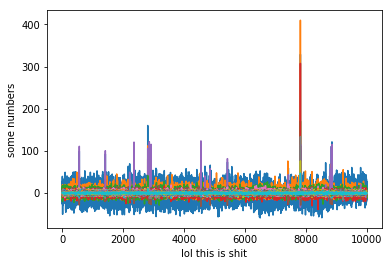

In [74]:
"""now the PCA"""
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=50)
x = pca.fit_transform(x)
print(x.shape)


plt.plot(x)
plt.ylabel('some numbers')
plt.xlabel('lol this is shit')
plt.show();


In [67]:
"""This again takes some time"""
from sklearn.manifold import TSNE

tsne = TSNE()
x = tsne.fit_transform(x)
print(x.shape)

(100, 2)


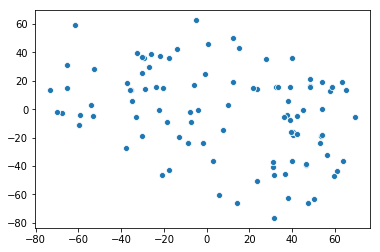

In [71]:
"let's plot just the first 100 sentences"
import seaborn as sns
x_short = x[:100]
print(x_short.shape)
sns.scatterplot(x_short[:,0], x_short[:,1])

#### Preparing the Dataset (yes again)
We now want to transform our embedded sentence vectors like:
- No more sentence pairs
- Labels added(0 = invalid, 1 = valid)
- Thus shape should be: (20000, n_features, 2)

With this we should be able to make a nice plot (still probl not really helpful), but more importantly, can feed this new array into a classifier model and see what that spits out.

### AGAIN a fking problem with the array

In [87]:
for i, row in enumerate(npy_task_A):
    #print(i, row[1].shape)
    npy_task_A[i][1] = np.reshape(row[1], (768,))

In [96]:
alsl = np.asarray([[1,2],[3,4],[5,6]])
print( alsl.shape)
for row in alsl:
    print(row.shape)
    for col in row:
        print(col)

(3, 2)
(2,)
1
2
(2,)
3
4
(2,)
5
6


# WAT THA FAK

In [92]:
"""Preparing data"""
# first make sure we have the right arrays
data = npy_task_A
labels = answers_task_A # shows the index of the invalid answer
print('data shape:', data.shape, 'labels shape:', labels.shape)

# now for the transformation
data_long = []
labels_long = []
for row, invalid_index in zip(data, labels):
    print(row.shape)
    for i, col in enumerate(row):
        #row = np.reshape(col, (768,))
        print(col.shape)
        data_long.append(col)
        
        # add the corresponding label
        if invalid_index == i:
            labels_long.append(0)
        else: labels_long.append(1)
    
    print('why dafuq does it stop here', row.shape, invalid_index)
    
data_long = np.asarray(data_long)
labels_long = np.asarray(labels_long)
print('new shape:', data_long.shape, 'labels shape:', labels_long.shape)
print('first four entries:', data_long[:4], 'corresponding labels:', labels_long[:4])



data shape: (10000, 2) labels shape: (10000, 1)
(2,)
(768,)
(768,)
why dafuq does it stop here (2,) 1
new shape: (2, 768) labels shape: (2,)
first four entries: [[-0.9297565  -0.44934916 -0.8985311  ... -0.8033828  -0.72360754
   0.95161486]
 [-0.91007304 -0.38069984 -0.8652086  ... -0.7399297  -0.67839175
   0.9478358 ]] corresponding labels: [1 0]


## NExt STEPs:

- go through dataset and see which words differ
- get dependent words through pos tags
- run these words through BERT
- get word embeddings as output
- compute vector distance
- whichever distance is lower is better ???
    - maybe have control sentences, but where from?
- output is a measure of the difference of the distances

All of this (without first, maybe second step) cann happen in a model?

In [96]:
import math
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)


a=['I put a turkey into the fridge', 'I put a elephant the fridge']
print([score(i) for i in a])

W1205 12:23:18.874933 4558089664 tokenization_openai.py:141] ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


[133.0363788241483, 13605.462201234779]


In [92]:
a=['Pouring milk on my cereal', 'Pouring orangejuice on my cereal']
print([score(i) for i in a])
a=['I drink apple', 'I drink milk']
print([score(i) for i in a])
a=['John ran a mile yesterday', 'John ran 100.000 miles yesterday']
print([score(i) for i in a])
a=['Hold my tits', 'Hold my beer']
print([score(i) for i in a])

[385.0906700452085, 738.7083743906966]
[13233.921159142094, 4031.916840866506]
[1270.5987178679527, 1946.7255548497253]
[722.3442951187566, 320.8368294456649]


'2.0.0'